In [1]:
#Imports some of the libraries that we will be using
import pandas as pd
import numpy as np
import math
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
warnings.filterwarnings('ignore')


In [2]:
from load_dataset import load, load_acsincome, load_compas
from classifier import NeuralNetwork, Logistic_Regression, SVM
from utils import *
from metrics import *  # include fairness and corresponding derivatives
from expl import explanation_candidate_generation, get_top_k_expl
from influence import *

['acs_income.csv', 'acs_influence.ipynb', 'adult.data', 'adult.test', 'adult_influence.ipynb', 'classifier.py', 'compas-scores-two-years.csv', 'compas_influence.ipynb', 'config.json', 'expl.py', 'functions.py', 'german.data', 'german_influence.ipynb', 'influence.py', 'load_dataset.py', 'loss.py', 'metrics.py', 'utils.py', '__pycache__']


<h4>Build model and get the influence points<h4>

In [3]:
dataset = 'acsincome'
clf_name = 'Logistic_Regression'
metric = 0
support = 0.05
support_small = 0.3

In [4]:
X_train, X_test, y_train, y_test = load(dataset)

In [5]:
X_train

,POBP,WKHP,ST,COW_SE_business,COW_SE_no_business,COW_federal_gov,COW_local_gov,COW_no_pay_work,COW_non-profit,COW_private_business,...,OCCP_production_transportation,OCCP_sales,OCCP_service,RELP_family,RELP_inlaws/other,RELP_non-family,RAC1P_poc,RAC1P_white,AGEP_old,AGEP_young
0,42.0,60.0,42.0,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,True,False,True
1,12.0,10.0,2.0,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,True,False,True
2,26.0,45.0,6.0,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,True,True,False
3,27.0,8.0,27.0,False,False,True,False,False,False,False,...,False,True,False,True,False,False,True,False,False,True
4,54.0,40.0,54.0,False,False,False,True,False,False,False,...,False,False,True,True,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,51.0,15.0,51.0,False,False,False,False,False,False,True,...,False,True,False,True,False,False,False,True,False,True
796,13.0,40.0,36.0,False,False,True,False,False,False,False,...,False,True,False,True,False,False,True,False,False,True
797,17.0,60.0,17.0,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,True,False,True
798,53.0,3.0,53.0,False,False,False,True,False,False,False,...,True,False,False,True,False,False,True,False,True,False


In [59]:
#Drop the unecessary columns
X_train = X_train.drop(columns=['RAC1P_white','RAC1P_poc','SEX_female','AGEP_old','AGEP_young'])
X_test = X_test.drop(columns=['RAC1P_white','RAC1P_poc','SEX_female','AGEP_old','AGEP_young'])

In [60]:
duplicates = 1
make_duplicates = lambda x, d: pd.concat([x]*d, axis=0).reset_index(drop=True)
X_train = make_duplicates(X_train, duplicates)
X_test = make_duplicates(X_test, duplicates)
y_train = make_duplicates(y_train, duplicates)
y_test = make_duplicates(y_test, duplicates)

In [61]:
#List of time take to decide data points
sol_time = []

In [62]:
import copy
X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [63]:
print(len(X_test))
print(len(X_train))
print(len(y_test))
print(len(y_train))

200
800
200
800


In [64]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [65]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.21716602106705046
Initial TPR parity:  -0.14083049819603854
Initial predictive parity:  -0.2101012560635348
Initial accuracy:  0.785


<h4>Calculate the Influence of the datapoints<h4>

In [66]:
#Original datapoints before changing the datapoints
if_start = time.time()
metric_val = [spd_0, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta = get_del_F_del_theta(clf, X_test_orig, X_test, y_test, dataset, metric)

In [67]:
hessian_all_points = get_hessian_all_points(clf, X_train, y_train, loss_func)

100%|██████████| 800/800 [00:20<00:00, 38.63it/s]


In [68]:
del_L_del_theta = get_del_L_del_theta(clf, X_train, y_train, loss_func)

In [69]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta))
#incorporate del_l_del_theta_i with the updated datapoint

In [70]:
inf = np.matmul(np.transpose(hinv_v), del_F_del_theta)
#For the new datapoint re-calculate the hinv_v

In [71]:
inf=(1/len(X_train))*(inf)

In [72]:
inf

array([-1.76338062e-04, -1.97260652e-04, -7.46767674e-05,  1.39314662e-03,
       -1.39494354e-03, -3.23243992e-04, -1.09638603e-03,  4.97360146e-04,
        5.43388720e-04, -7.26114096e-06, -4.08121574e-04,  6.00483991e-04,
       -9.25953374e-04,  1.08129366e-03,  7.01607200e-04, -1.09777032e-03,
        5.79468458e-04, -7.20453080e-04,  6.46564341e-04,  8.42849724e-04,
       -4.97218379e-04, -4.30610214e-04, -7.03508220e-04,  4.08075376e-04,
       -2.95236709e-04, -1.01523837e-04, -6.25763650e-04, -5.12903664e-05,
        2.13427148e-06, -1.19728070e-04, -1.93397540e-04,  8.83456344e-04,
       -3.00935386e-04, -5.35261531e-04, -7.52629272e-04, -1.14851916e-04,
       -3.13998270e-04,  3.38093609e-04, -3.38932979e-04,  6.43902201e-04,
        4.80875785e-04, -1.69304675e-04,  3.60638289e-04,  6.21374313e-04,
       -6.77219748e-05, -1.31770689e-04,  1.78490617e-03, -1.16304367e-03,
       -1.27849591e-03, -2.50206706e-04,  9.59978307e-04, -6.21830584e-04,
       -3.85473131e-04, -

<h4>Calculate the influence of flipped datapoints<h4>

In [73]:
#Flip all the labels for the encoded data and the scaled data
#The labels are the same just the training data looks different 
y_train_changed = y_train.replace({0:1,1:0})
y_test_changed = y_test.replace({0:1,1:0})

In [74]:
#Run the Classifiers and calculate the statistical parity after changing everything
#In theory it shouldnt change anything but uhhhh lets see 
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [75]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train_changed)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_1 = computeFairness(y_pred_test, X_test_orig, y_test_changed, 0, dataset)
print("Initial statistical parity: ", spd_1)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test_changed, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test_changed, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

accuracy_0 = computeAccuracy(y_test_changed, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  0.21786160885554479
Initial TPR parity:  0.15608851561675197
Initial predictive parity:  0.18922332564384525
Initial accuracy:  0.785


In [76]:
#Original datapoints before changing the datapoints
if_start = time.time()
metric_val = [spd_1, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta = get_del_F_del_theta(clf, X_test_orig, X_test, y_test, dataset, metric)

In [77]:
hessian_all_points = get_hessian_all_points(clf, X_train, y_train, loss_func)

100%|██████████| 800/800 [00:20<00:00, 38.29it/s]


In [78]:
del_L_del_theta = get_del_L_del_theta(clf, X_train, y_train, loss_func)

In [79]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta))
#incorporate del_l_del_theta_i with the updated datapoint

In [80]:
inf3 = np.matmul(np.transpose(hinv_v), del_F_del_theta)
#For the new datapoint re-calculate the hinv_v

In [81]:
inf3=(1/len(X_train))*(inf3)

In [82]:
inf3

array([-2.41468863e-03, -1.40929855e-03, -1.55799636e-03,  1.08936687e-03,
       -1.55277099e-03, -5.45830215e-04, -1.95484107e-03,  1.73955101e-03,
        6.61858198e-04, -2.33761789e-05, -7.83677802e-04,  1.08457955e-03,
       -7.20862746e-04,  1.71591262e-03,  2.28650327e-03, -8.19998582e-04,
        4.15718994e-04, -1.61596852e-03,  2.45813322e-03,  1.47560170e-03,
       -1.21101785e-03, -8.82862428e-04, -1.15397238e-03,  1.43218919e-03,
       -7.15004617e-04, -1.07546434e-03, -1.00884081e-03, -1.41205559e-03,
        2.74591781e-06, -4.70992522e-04, -7.10340992e-04,  1.85781382e-03,
       -7.42940152e-04, -2.35978543e-04, -1.10859830e-03, -2.56023031e-03,
       -1.95971318e-03,  1.23525172e-03, -1.59518509e-03,  1.27644952e-03,
        9.74094881e-04, -1.43075193e-03,  1.58223399e-03,  6.90968851e-04,
       -9.79084249e-04, -1.25576160e-03,  9.21088280e-04, -1.29940871e-03,
       -7.68758904e-04, -1.54091304e-03,  3.93018080e-03, -3.12097892e-03,
       -1.56958209e-03, -

<h4>Determine total influence of datapoints<h4>

In [83]:
total_inf = inf3 - inf
if_end = time.time()
if_time1 = if_start - if_end

In [84]:
print(max(total_inf))
print(min(total_inf))
print(len(total_inf))
print(type(total_inf))
print(total_inf.dtype)

0.004587411900271273
-0.0034670650841094075
800
<class 'numpy.ndarray'>
float64


<h4>Make sure everything is working by comparing the predicted values
Vs the actualy<h4>

In [85]:
#Set up predictors and target variable
acs_columns_list = list(X_test_orig.columns)
target_var = 'PINCP'
predictors = [item for item in acs_columns_list if item != 'PINCP']

In [86]:
#Function to run the logistic regression model based on classifier.py
def lr_model(training_df, test_attr_df, classifier):
    changed_df_labels = training_df.pop('PINCP')
    changed_df_attr = training_df.to_numpy()

    classifier.fit(changed_df_attr,changed_df_labels.values)
    y_predicted = classifier.predict_proba(test_attr_df)

    training_df['PINCP'] = changed_df_labels

    return y_predicted

In [87]:
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(X_train, columns = predictors)
train_outcome_df = y_train.to_frame()
#train_outcome_df=train_outcome_df.rename(columns={'PINCP':'PINCP'})
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [ ]:
copy_train = train_full_df.copy()
difference = []

for index in copy_train.index:
    df_dropped = copy_train.copy()
    df_dropped = copy_train.drop(index)
    #Run lr_model() to get predicted probabilities
    ypred = lr_model(df_dropped, X_test, clf)
    parity = computeFairness(ypred, X_test_orig, y_test, 0, dataset)
    
    parity = parity-spd_0

    difference.append(parity)
    print(index)
#This does not fall under the measuring the time taken to decide how long it will take for IF to work 

In [89]:
decimal_array = [format(num, '.10f') for num in inf]
decimal_array = [float(num) for num in decimal_array]
print(decimal_array)

[-0.0001763381, -0.0001972607, -7.46768e-05, 0.0013931466, -0.0013949435, -0.000323244, -0.001096386, 0.0004973601, 0.0005433887, -7.2611e-06, -0.0004081216, 0.000600484, -0.0009259534, 0.0010812937, 0.0007016072, -0.0010977703, 0.0005794685, -0.0007204531, 0.0006465643, 0.0008428497, -0.0004972184, -0.0004306102, -0.0007035082, 0.0004080754, -0.0002952367, -0.0001015238, -0.0006257637, -5.12904e-05, 2.1343e-06, -0.0001197281, -0.0001933975, 0.0008834563, -0.0003009354, -0.0005352615, -0.0007526293, -0.0001148519, -0.0003139983, 0.0003380936, -0.000338933, 0.0006439022, 0.0004808758, -0.0001693047, 0.0003606383, 0.0006213743, -6.7722e-05, -0.0001317707, 0.0017849062, -0.0011630437, -0.0012784959, -0.0002502067, 0.0009599783, -0.0006218306, -0.0003854731, -0.000570299, 0.0004821947, -0.0004117047, 0.0014686305, -0.0006571097, -0.0001319259, 0.0009463785, 0.0026862852, -0.0001120427, -0.0027592482, 0.0010586947, -0.0001835289, -9.4861e-05, 0.0018800511, 0.0006427941, 0.0011091786, -0.000

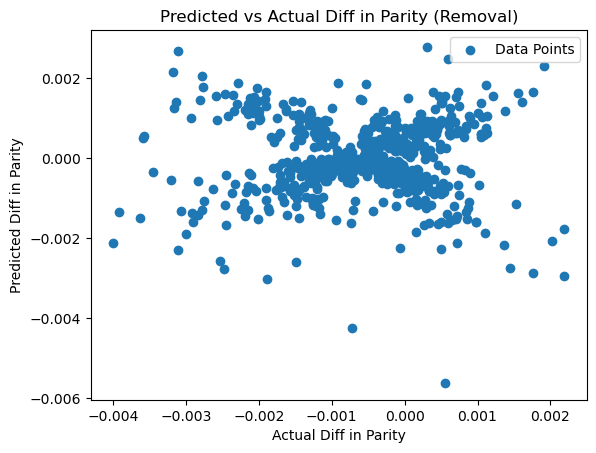

In [90]:
# Assuming your lists are named `predicted_diff` and `actual_diff`
predicted_diff = decimal_array
actual_diff = difference

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff, label='Data Points')

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (Removal)')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [91]:
if_start = time.time()
index_list = []
list_len = len(X_train)+ len(y_train)
for i in range(list_len):
    index_list.append(i)

In [92]:
#Make a copy of the training data to make flips on 
influence_train_copy = train_full_df.copy()

In [93]:
#Order the total_inf in descending order based on magnitude
combined_list = list(zip(total_inf, index_list))

# Step 2: Sort the combined list based on the float values
sorted_combined_list = sorted(combined_list, key=lambda x: abs(x[0]), reverse=True)

# Step 3: Unpack the sorted list of tuples back into two separate lists
abs_sorted_float_list, abs_sorted_index_list = zip(*sorted_combined_list)
list(abs_sorted_float_list)
list(abs_sorted_index_list)
#Measure up to here for the influence functions
#This will tell us how long it takes for influence functions to determine which order I need to flip the datapoints in
#if_time: Time taken to decide the order in which the datapoints need to be flipped
if_end = time.time()
if_time2 = if_end-if_start
if_time2 += if_time1
print(if_time2)

-21.442115306854248


In [94]:
if if_time2 < 0:
    if_time2 = -1 * if_time2
else: 
    pass

In [95]:
flip_parity_abs = []
for i in range(len(abs_sorted_index_list)):
    row_num = abs_sorted_index_list[i]
    if influence_train_copy.at[row_num,'PINCP'] == 1:
        influence_train_copy.at[row_num,'PINCP'] = 0
        influence_prediction = lr_model(influence_train_copy, X_test, clf)
        influence_parity = computeFairness(influence_prediction, X_test_orig, y_test, 0, dataset)
        flip_parity_abs.append(influence_parity)
    elif influence_train_copy.at[row_num,'PINCP'] == 0:
        influence_train_copy.at[row_num,'PINCP'] = 1
        influence_prediction = lr_model(influence_train_copy, X_test, clf)
        influence_parity = computeFairness(influence_prediction, X_test_orig, y_test, 0, dataset)
        flip_parity_abs.append(influence_parity)
print(flip_parity_abs)

KeyboardInterrupt: 

In [ ]:
sol_time.append(if_time2)

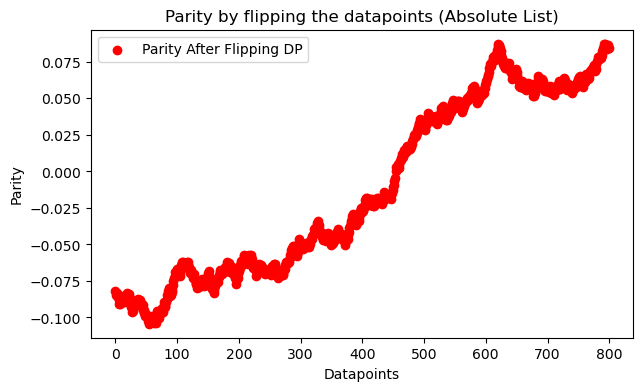

In [ ]:
#Graph the points
# Assuming the X-axis is some common range or specific values
size = range(len(flip_parity_abs))  # X values for list data

# Create the plot
plt.figure(figsize=(7, 4))

# Plot list data with dots
plt.scatter(size, flip_parity_abs, color='red', label='Parity After Flipping DP', marker='o')

# Adding labels
plt.xlabel('Datapoints')
plt.ylabel('Parity')

# Adding title and legend
plt.title('Parity by flipping the datapoints (Absolute List)')
plt.legend()

# Display the plot
plt.show()

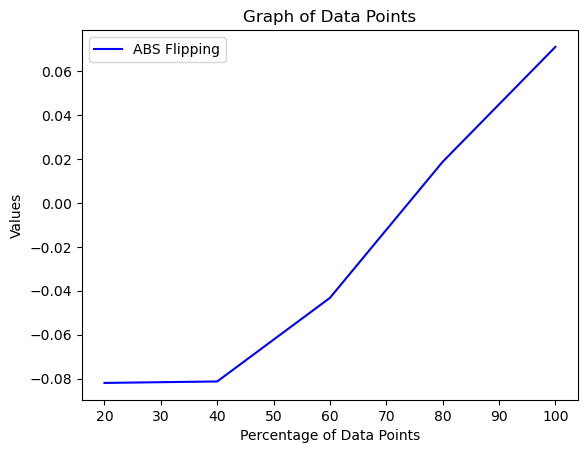

In [ ]:
#total num of data points
#on_abs_sorted = len(flip_parity_sorted)
abs_sorted = len(flip_parity_abs)

#Calculate the indices for the 5 points
#indices_non_abs = [int(i * non_abs_sorted / 5) for i in range(0, 5)]
indices_abs = [int(i * abs_sorted / 5) for i in range(0, 5)]

# Extract the values at these indices
#values_non_abs = [flip_parity_sorted[index] for index in indices_non_abs]
values_abs = [flip_parity_abs[index] for index in indices_abs]

#Plot the Values
plt.plot([20, 40, 60, 80, 100], values_abs, label='ABS Flipping', color='Blue')

# Add labels and legend
plt.xlabel('Percentage of Data Points')
plt.ylabel('Values')
plt.title('Graph of Data Points')
plt.legend()

# Show the plot
plt.show()

<h4>Comparing INF to Entropy and Randomized<h4>

<h5>Entropy<h5>

In [ ]:
entropy_start = time.time()
#Remake the dataset
entropy_train_df = train_full_df.copy()

In [ ]:
#Run the LR classifier
#Use Scikit learn logistic regression rather than pre-built one
clfa = LogisticRegression(class_weight=None, max_iter=100)
log = clfa.fit(X_train,y_train)
prediction = log.predict(X_test)
#prediction_prob = log.predict_proba(X_train)
accuracy = accuracy_score(y_test,prediction)*100
print(accuracy)

72.0


In [ ]:
#Obtain the predicted probabilities
predicted_prob = log.predict_proba(X_train)

In [ ]:
#Log base two would be: log = math.log(x,2)
#Entropy equation would then be: -1*(p1((math.log(p1,2))+p2*(math.log(p2,2)))

#In the predicted_probabilities: first value is 0 (which is bad), second value is 1 (which is good)

#Loop through the predicted_probabilities array and calculate values
#One list will contain the index of each row in the table and the other will contain the entropy value of each row

index_list = []
entropy_list = []

for index, value in enumerate(predicted_prob):
  #Calculate p1 and p2
  p1=predicted_prob[index,0]
  p2=predicted_prob[index,1]
  #Calculate entropy in 3 steps
  entropy_calc1 = p1 * math.log(p1,2)
  entropy_calc2 = p2 * math.log(p2,2)
  entropy_final = -1 * (entropy_calc1 + entropy_calc2)

  #Append the values to their respective lists
  index_list.append(index)
  entropy_list.append(entropy_final)

In [ ]:
#Rank the entropy values in decreasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(entropy_list, index_list))

#Sort the combined lust based on entropy values in descending order
sorted_list = sorted(combined_list, key = lambda x: x[0], reverse=True)

#Extract the values
sorted_ent_list, sorted_index_list = zip(*sorted_list)
entropy_end = time.time()

In [ ]:
entropy_train_df['PINCP'] = entropy_train_df['PINCP'].astype('int')

In [ ]:
ranked_ent_list = list(sorted_ent_list)
ranked_idx_list = list(sorted_index_list)

In [ ]:
#After the ranking; flip based on the ranked entropy values
#Values with the highest entropy are prioritized for flipping

ranked_ent_parity_list = [spd_0]
ranked_flip = []

row_num = 0

#Loop through and flip based on the entropy values
for row in range(len(sorted_index_list)):
    row_num = ranked_idx_list[row]
    if entropy_train_df.at[row_num,'PINCP'] == 0:
        entropy_train_df.at[row_num,'PINCP'] = 1
        ranked_ent_pred = lr_model(entropy_train_df, X_test, clf)
        ranked_ent_parity = computeFairness(ranked_ent_pred, X_test_orig, y_test, 0, dataset)
        ranked_ent_parity_list.append(ranked_ent_parity)

    elif entropy_train_df.at[row_num,'PINCP'] == 1:
        entropy_train_df.at[row_num,'PINCP'] = 0
        ranked_ent_pred = lr_model(entropy_train_df, X_test, clf)
        ranked_ent_parity = computeFairness(ranked_ent_pred, X_test_orig, y_test, 0, dataset)
        ranked_ent_parity_list.append(ranked_ent_parity)

In [ ]:
entropy_time = entropy_end - entropy_start
sol_time.append(entropy_time)

<h5>Randomized<h5>

In [ ]:
#Training dataset
random_start = time.time()
random_training_df = train_full_df.copy()

In [ ]:
#Budget of 200 random flipping
import random
random_flip_parity = []
budget = len(y_test)

for iter in range(budget):
    random_row = random.choice(random_training_df.index)
    if random_training_df.at[random_row,'PINCP'] == 1:
        random_training_df.at[random_row,'PINCP'] = 0
        rand_pred = lr_model(random_training_df, X_test, clf)
        rand_ranked_parity = computeFairness(rand_pred, X_test_orig, y_test, 0, dataset)
        random_flip_parity.append(rand_ranked_parity)
    elif random_training_df.at[random_row,'PINCP'] == 0:
        random_training_df.at[random_row,'PINCP'] = 1
        rand_pred = lr_model(random_training_df, X_test, clf)
        rand_ranked_parity = computeFairness(rand_pred, X_test_orig, y_test, 0, dataset)
        random_flip_parity.append(rand_ranked_parity)
random_end = time.time()


In [ ]:
random_time = random_end - random_start
sol_time.append(random_time)

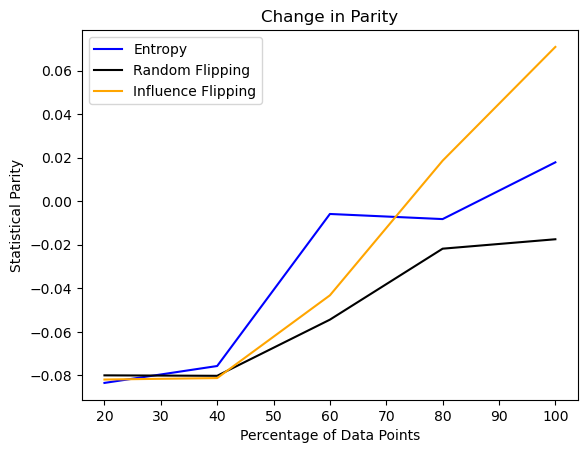

In [ ]:
# Calculate the total number of data points
datapoints_entropy = len(ranked_ent_parity_list)
datapoints_random = len(random_flip_parity)
datapoints_influence = len(flip_parity_abs)

# Calculate the indices for the 5 points
indices_entropy = [int(i * datapoints_entropy / 5) for i in range(0, 5)]
indices_random = [int(i * datapoints_random / 5) for i in range(0, 5)]
indices_influence = [int(i * datapoints_influence / 5) for i in range(0, 5)]

# Extract the values at these indices
values_entropy = [ranked_ent_parity_list[index] for index in indices_entropy]
values_random = [random_flip_parity[index] for index in indices_random]
values_influence = [flip_parity_abs[index] for index in indices_influence]

# Plot the values
plt.plot([20, 40, 60, 80, 100], values_entropy, label='Entropy', color='Blue')
plt.plot([20, 40, 60, 80, 100], values_random, label='Random Flipping', color='Black')
plt.plot([20, 40, 60, 80, 100], values_influence, label='Influence Flipping', color='Orange')

# Add labels and legend
plt.xlabel('Percentage of Data Points')
plt.ylabel('Statistical Parity')
plt.title('Change in Parity')
plt.legend()

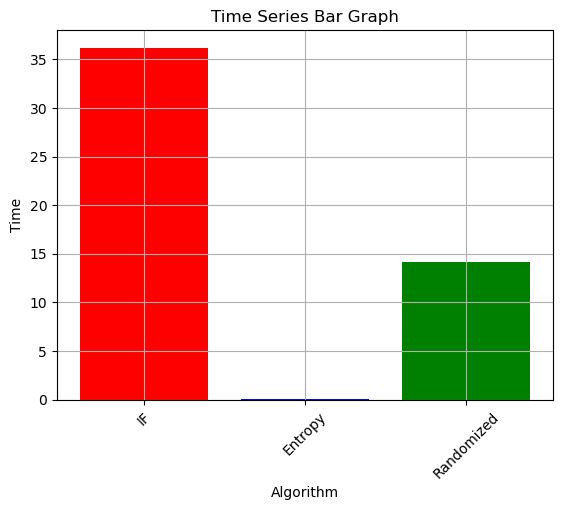

In [ ]:
# Create a line chart
x_axis = ['IF','Entropy','Randomized']
# Colors for each bar
colors = ['red', 'blue', 'green']

# Create a bar graph with updated labels and colors
plt.bar(x_axis, sol_time, color=colors)
plt.title('Time Series Bar Graph')
plt.xlabel('Algorithm')
plt.ylabel('Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [ ]:
sol_time

[36.17913484573364, 0.046690940856933594, 14.142665386199951]